<a href="https://colab.research.google.com/github/stefanogiagu/corso_AML_2022/blob/main/notebooks/es6/AML_2022_6_U_Net_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Machine Learning for Physics 2021-2022
## Hands-on session 6

In this session, we will implement a simple image segementation model based on the U-Net architecture  trained for the task of segmenting satellite images of clouded sky from the 38-cloud dataset.

My different model architectures can be used for a pixel-level segmentation of images (FC ResNet101, DeepLabV3 ResNet101, U-Net, ...). To reach high performance the architecture are very deep and complex, which means also that they requires a lot of memory and time to train. In order to implement one of these models in google colab and with the time constraint of an hands-on session, we'll use a simplified (cut-down) version of the U-Net architecture, originally proposed for biomedical image segmentation in 2015 ([arXiv:1505.04597](https://arxiv.org/abs/1505.04597)).

The simplified implementation is from Mauricio Cordeiro.

The U-Net architecture we will implements is pictured in the following image and consists in 3 downsampling (or contracting) blocks and 3 upsampling (or expanding) blocks:

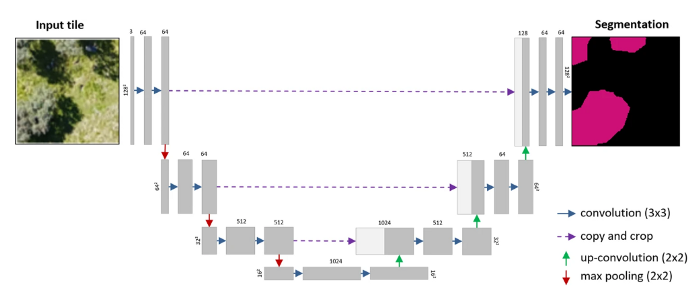


The contrating blocks is a set of convolutions with pooling that downsizes the image resolution and creates additional layers to extract “features” from the original image.

The first and second contraction blocks are composed of 2 convolutions (indicated as the blue arrows, in this case with kernel size 3x3) and a max pooling of stride 2x2 that cuts in half the size of the input image (in this case from 128x128 to 64x64). 

The original U-Net model has a middle block, also known as “bottleneck”, with some more convolutions to increase the number of features. To simplify the model this part is not implemented here, and after the contracting block we go directly to the expanding part, based on transpose convolutions to increase the resolution.

A specific feature of the U-Net architecture are the skip-connections between the output of a contraction block and the input of the corresponding upsampling block, represented in the diagram as a horizontal arrows. With the use of skyp conections the input for the second expanding block is not only the output from the previous expanding (green arrow), but also the output from the last contraction block before the max pooling. The meaning of this skip connection is that the convolution of the second expanding block will perform in all the layers of the previous block concatenated with the layers from the contract block (shown as light and dark grey squares in th enext figure).

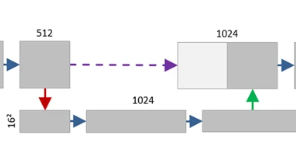

To simplify the implementation the max pooling is combined with the convolutions into a single sequential container, and the previous contraction block is used as input to the expanding block:

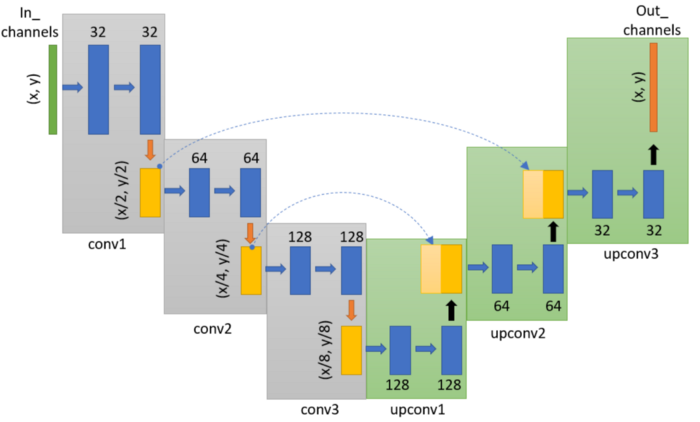

## Dataset

Kaggle 38-Cloud: Cloud Segmentation in Satellite Images ([doc link](https://github.com/SorourMo/38-Cloud-A-Cloud-Segmentation-Dataset))

This dataset contains 38 Landsat 8 scene images and their manually extracted pixel-level ground truths for cloud detection.

The entire images of these scenes are cropped into multiple 384*384 patches to be proper for deep learning-based semantic segmentation algorithms. There are 8400 patches for training and 9201 patches for testing (in the hands-on we'll use only the training set splitting it in trainign and validation). Each patch has 4 corresponding spectral channels which are Red (band 4), Green (band 3), Blue (band 2), and Near Infrared (band 5). Unlike other computer vision images, these channels are not combined. Instead, they are in their corresponding directories.

The dataset is 15GB in size, to avoid long downloading times has been copied on a shared google drive folder:

https://drive.google.com/drive/folders/1UQaQSFldPUNaB1_Or1On6NR0QClTeJsC?usp=sharing



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time

In [113]:
#Dataset

class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):
        
        #print(b_file, g_dir, r_dir, nir_dir, gt_dir)
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}
        

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False, standard=True):

        if standard:
          raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                              np.array(Image.open(self.files[idx]['green'])),
                              np.array(Image.open(self.files[idx]['blue'])),
                             ], axis=2)
        
        else:
          raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),], axis=2)


        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=False, standard=False), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [67]:
!ls /content/drive/MyDrive/Didattica2022/Datasets/38-Cloud_training/train_red/ | wc
!ls /content/drive/MyDrive/Didattica2022/Datasets/38-Cloud_training/train_green/ | wc
!ls /content/drive/MyDrive/Didattica2022/Datasets/38-Cloud_training/train_blue/ | wc
!ls /content/drive/MyDrive/Didattica2022/Datasets/38-Cloud_training/train_nir/ | wc
!ls /content/drive/MyDrive/Didattica2022/Datasets/38-Cloud_training/train_gt/ | wc

   8400    8400  562270
   8400    8400  579070
   8400    8400  570670
   8400    8400  562270
   8400    8400  553870


In [114]:
base_path = Path('/content/drive/MyDrive/Didattica2022/Datasets/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
print('Dataset size: ',len(data))

Dataset size:  8400


In [115]:
x, y = data[1000]
x.shape, y.shape

(torch.Size([1, 384, 384]), torch.Size([384, 384]))

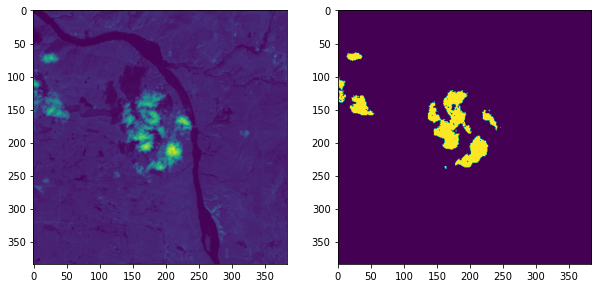

In [116]:
examp = 2480

fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(examp, invert=False, include_nir=False, standard=False).reshape((384,384)))
ax[1].imshow(data.open_mask(examp))

In [117]:
train_ds, valid_ds, test_ds = torch.utils.data.random_split(data, (2000, 2000, 4400))

In [118]:
train_dl = DataLoader(train_ds, batch_size=12, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=12, shuffle=True)

In [119]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 1, 384, 384]), torch.Size([12, 384, 384]))

In [120]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [121]:
#takes 1 channels (red) as input and returns 2 channels to segment cloud and clear conditions.
unet = UNET(1,2)

In [123]:
# testing one pass
# takes 1 channel (r) as input and returns 2 channels to segment cloud and clear conditions.

xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 1, 384, 384]), torch.Size([12, 384, 384]))

In [124]:
pred = unet(xb)
pred.shape

torch.Size([12, 2, 384, 384])

In [125]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss.detach()*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [126]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr=0.01)
train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=20)

Epoch 19/19
----------
valid Loss: 0.2035 Acc: 0.922111451625824
----------
Training complete in 38m 36s


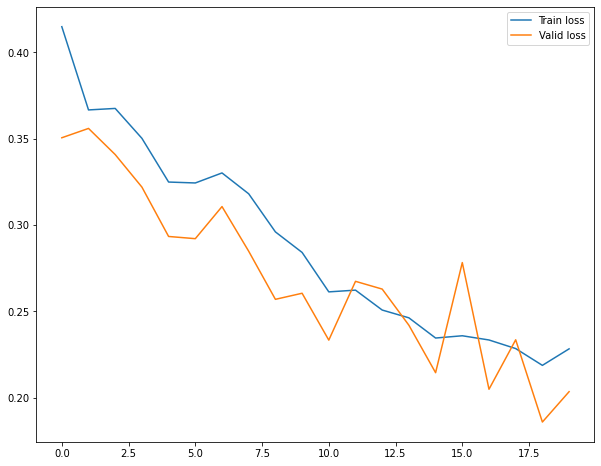

In [127]:
plt.figure(figsize=(10,8))
plt.plot([item.cpu() for item in train_loss], label='Train loss')
plt.plot([item.cpu() for item in valid_loss], label='Valid loss')
plt.legend()

In [128]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [133]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = unet(xb.cuda())

predb.shape

torch.Size([12, 2, 384, 384])

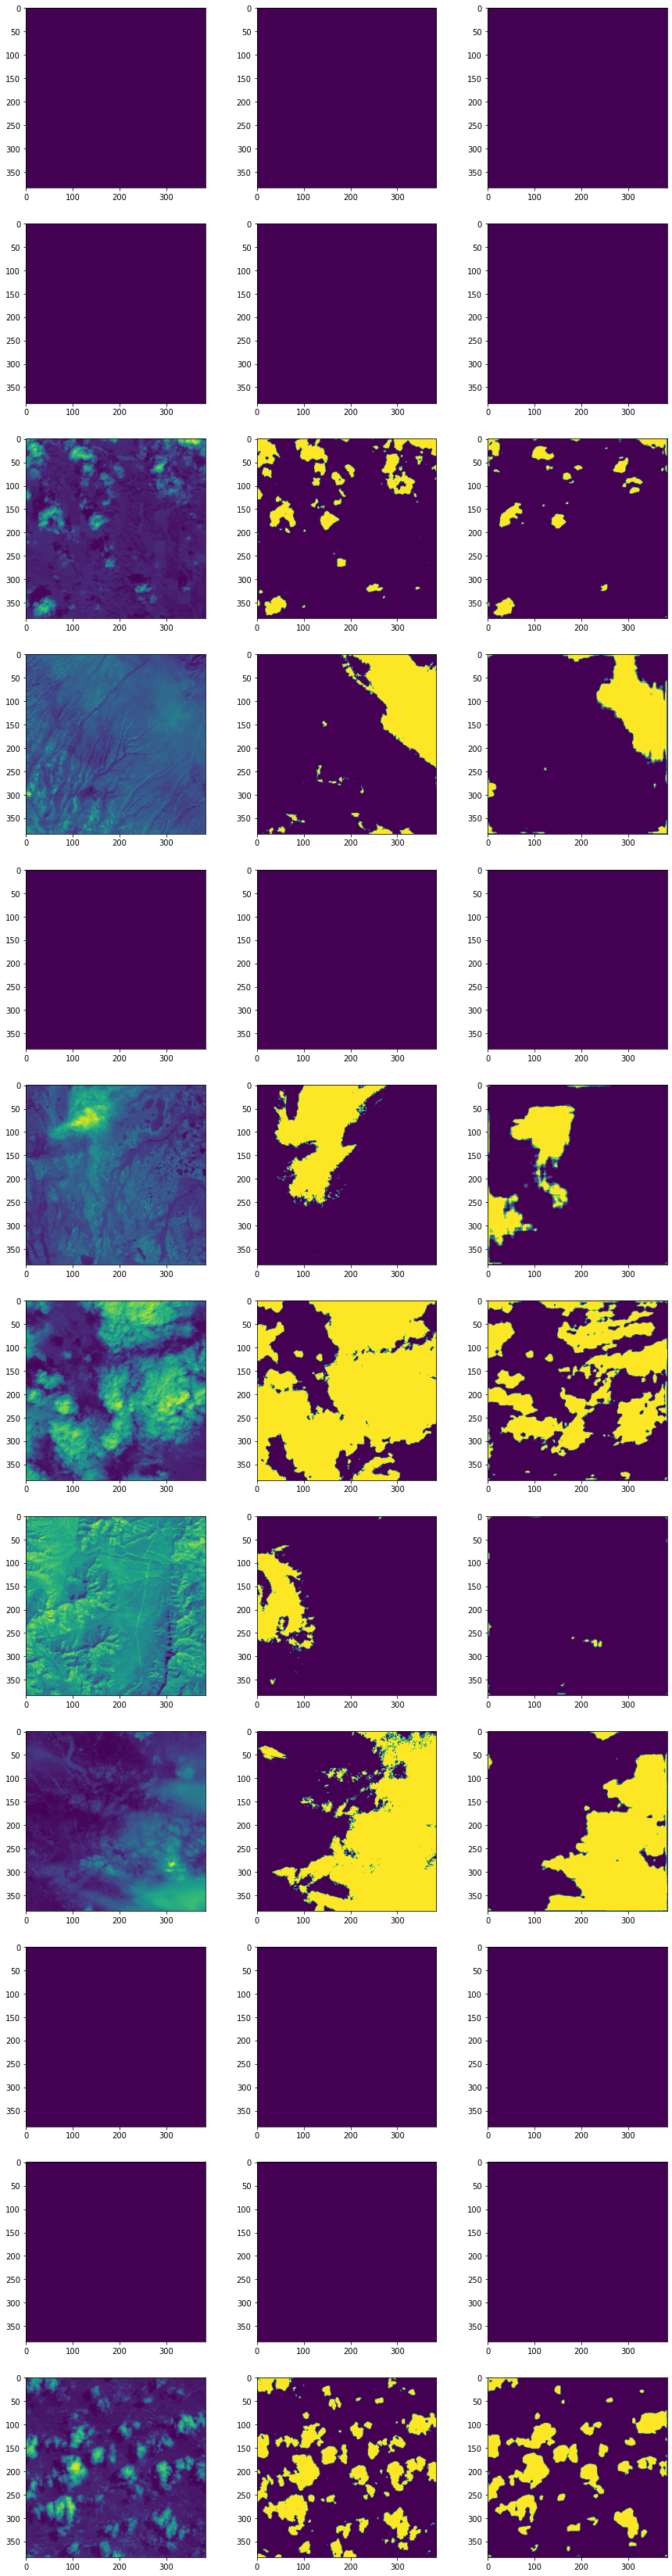

In [134]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i).reshape((384,384)))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

### Experiment youself:

*   use other metrics to evaluate/monitor the performance of the algorithm (IoU, SSIM, ...)
*   use the additional available features for the input images (red, blu, green and nir (near infrared) satellite images), to improve the segmentation accuracy 

